<a href="https://colab.research.google.com/github/EkaSulistyawan/strawberry-segmentation/blob/main/IIS_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import torch
from PIL import Image
import torchvision
import math
import sys
import time
import matplotlib.pyplot as plt

import os

# It takes quite long time to train a GAN, better to save the snapshots/final model in your drive.
# Mount GoogleDrive here.
from google.colab import drive
drive.mount('/content/gdrive/')
root_path = '/content/gdrive/MyDrive/downsampled_StrawDI_f1/'

! cp '/content/gdrive/MyDrive/Colab Notebooks/utils.py' .
! cp '/content/gdrive/MyDrive/Colab Notebooks/transforms.py' .
! cp '/content/gdrive/MyDrive/Colab Notebooks/engine.py' .
! cp '/content/gdrive/MyDrive/Colab Notebooks/coco_utils.py' .
! cp '/content/gdrive/MyDrive/Colab Notebooks/coco_eval.py' .

import utils
import transforms
import engine

Mounted at /content/gdrive/


In [ ]:
class StrawberryDataset(torch.utils.data.Dataset):
    def __init__(self,root,transforms,fact):
        self.root = root
        self.transforms = transforms
        # sort the images
        self.imgs = list(sorted(os.listdir(os.path.join(root,'images'))))
        self.masks = list(sorted(os.listdir(os.path.join(root,'label'))))
        self.f = fact

    def __getitem__(self,idx):
        # load images and masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "label", self.masks[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        # modify the size
        factor = self.f
        t = np.array(img)
        img = Image.fromarray(np.uint8(t[::factor,::factor,:]))
        t = np.array(mask)
        mask = Image.fromarray(np.uint8(t[::factor,::factor]))

        # convert mask to np
        mask = np.array(mask)

        #print(img)
        #print(mask.shape)


        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:] # assume the first obj is background (0)
        masks = mask== obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator

def get_model_instance_segmentation2(num_classes):

    backbone = torchvision.models.mobilenet_v2(pretrained=True).features
    # # FasterRCNN needs to know the number of
    # # output channels in a backbone. For mobilenet_v2, it's 1280
    # # so we need to add it here
    backbone.out_channels = 1280

    # # let's make the RPN generate 5 x 3 anchors per spatial
    # # location, with 5 different sizes and 3 different aspect
    # # ratios. We have a Tuple[Tuple[int]] because each feature
    # # map could potentially have different sizes and
    # # aspect ratios
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                       aspect_ratios=((0.5, 1.0, 2.0),))

    # # let's define what are the feature maps that we will
    # # use to perform the region of interest cropping, as well as
    # # the size of the crop after rescaling.
    # # if your backbone returns a Tensor, featmap_names is expected to
    # # be [0]. More generally, the backbone should return an
    # # OrderedDict[Tensor], and in featmap_names you can choose which
    # # feature maps to use.
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                     output_size=7,
                                                     sampling_ratio=2)


    mask_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                               output_size=14,
                                                               sampling_ratio=2)

    model = MaskRCNN(backbone,
                      num_classes=2,
                      rpn_anchor_generator=anchor_generator,
                      box_roi_pool=roi_pooler,
                      mask_roi_pool=mask_roi_pooler)


    return model

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    print("here")
    if train:
      #transforms.append(torchvision.transforms.Normalize((0.1307,), (0.3081,)))
      transforms.append(T.RandomHorizontalFlip(0.5))
    print("here")
    return T.Compose(transforms)

In [ ]:
def plot2(images,outputs,filename):
    immat = np.array(images[0].cpu().permute(1,2,0))

    maskmat = outputs[0]['masks'][0][0].detach().numpy()
    for i in range(0,outputs[0]['masks'].shape[0]):
        maskmat = maskmat + outputs[0]['masks'][i][0].detach().numpy()
    maskmat[maskmat <= 0.9] = 0
    immat[:,:,2] = immat[:,:,2] + maskmat*255
    plt.imshow(immat)
    plt.axis('off')
    plt.savefig(filename,bbox_inches='tight', pad_inches=0,dpi=300)

# For Mobile net

In [ ]:
# load model
path = f'{root_path}checkpoint/hanif/model_mobilenet_5epoch.pt'
model = get_model_instance_segmentation2(2)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
lr_scheduler.load_state_dict(checkpoint['scheduler'])
epoch = checkpoint['epoch']

#model.eval()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/gdrive/MyDrive/downsampled_StrawDI_f1/checkpoint/visualization/1715_mobilenet_5epoch


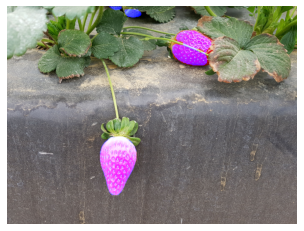

In [ ]:
f = 1
search = 1715

dataset_final_test =StrawberryDataset(f'{root_path}test/',transforms.ToTensor(),fact=f)

data_loader_final_test = torch.utils.data.DataLoader(
    dataset_final_test,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=utils.collate_fn)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

#imgs = []
filelist = list(sorted(os.listdir(os.path.join(f'{root_path}test/','images'))))
idx = filelist.index(f'{search}.png')
k = iter(data_loader_final_test)

for a in range(0,idx+1):
    imgs = next(k)[0]


image = list(img.to(device) for img in imgs)
model.eval()
outputs = model(image)


outputs = [{k: v.to(torch.device("cpu")) for k, v in t.items()} for t in outputs]
filename = f"{root_path}checkpoint/visualization/{search}_mobilenet_1400_5epoch"
plot2(image,outputs,filename)

# For ResNet50

In [ ]:
# load model
path = f'{root_path}checkpoint/hanif/model_resnet_5epoch.pt'
model = get_model_instance_segmentation(2)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
lr_scheduler.load_state_dict(checkpoint['scheduler'])
epoch = checkpoint['epoch']

#model.eval()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/gdrive/MyDrive/downsampled_StrawDI_f1/checkpoint/visualization/1580_resnet_5epoch


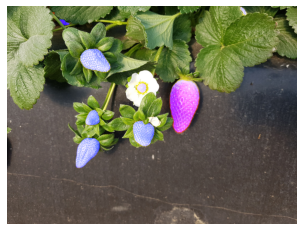

In [ ]:
f = 1
search = 1580

dataset_final_test =StrawberryDataset(f'{root_path}test/',transforms.ToTensor(),fact=f)

data_loader_final_test = torch.utils.data.DataLoader(
    dataset_final_test,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=utils.collate_fn)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

#imgs = []
filelist = list(sorted(os.listdir(os.path.join(f'{root_path}test/','images'))))
idx = filelist.index(f'{search}.png')
k = iter(data_loader_final_test)

for a in range(0,idx+1):
    imgs = next(k)[0]


image = list(img.to(device) for img in imgs)
model.eval()
outputs = model(image)


outputs = [{k: v.to(torch.device("cpu")) for k, v in t.items()} for t in outputs]
filename = f"{root_path}checkpoint/visualization/{search}_resnet_1400_5epoch"
plot2(image,outputs,filename)